In [2]:
import pandas as pd
import numpy as np 
import mplsoccer as mpl 
from mplsoccer import Pitch
import matplotlib.pyplot as plt
from statsbombpy import sb


In [3]:
sb.matches(55,282).head()
matchId = 3943043	

Getting the linup data for the match and mapping it to the event data 

In [4]:
lineup = sb.lineups(matchId)
lineups_df = pd.DataFrame()
for team_name, players_df in lineup.items():
    # Add team information to each player
    players_df['team_name'] = team_name
    
    # Append to the combined DataFrame
    lineups_df = pd.concat([lineups_df, players_df], ignore_index=True)
lineups_df.head()
player_name_dict = lineups_df.set_index('player_id')['player_name'].to_dict()
print(player_name_dict)


{3042: 'Mikel Merino Zazón', 3265: 'José Luis Sanmartín Mato', 3477: 'Álvaro Borja Morata Martín', 4127: 'David Raya Martin', 4353: 'Aymeric Laporte', 5202: 'José Ignacio Fernández Iglesias', 5721: 'Daniel Carvajal Ramos', 6655: 'Fabián Ruiz Peña', 6685: 'Mikel Oyarzabal Ugarte', 6748: 'Ferrán Torres García', 6765: 'Rodrigo Hernández Cascante', 6821: 'Jesús Navas González', 10336: 'Alejandro Grimaldo García', 11748: 'Unai Simón Mendibil', 16532: 'Daniel Olmo Carvajal', 17620: 'Marc Cucurella Saseta', 22128: 'Robin Aime Robert Le Normand', 24921: 'Martín Zubimendi Ibáñez', 32185: 'Alejandro Remiro Gargallo', 41115: 'Alejandro Baena Rodríguez', 41542: 'Daniel Vivian Moreno', 68574: 'Nicholas Williams Arthuer', 143864: 'Fermin Lopez Marin', 316046: 'Lamine Yamal Nasraoui Ebana', 3088: 'Lewis Dunk', 3205: 'Kyle Walker', 3244: 'John Stones', 3308: 'Kieran Trippier', 3382: 'Luke Shaw', 3468: 'Jordan Pickford', 3495: 'Joe Gomez', 3664: 'Trent Alexander-Arnold', 3822: 'Ezri Konsa Ngoyo', 3834:

In [5]:
import pandas as pd

def is_progressive(start_location, end_location):
    # Define the field boundaries
    own_half_end = 50  # The midpoint of the field

    # Calculate the distance moved closer to the opponent's goal
    distance_moved = end_location[0] - start_location[0]

    # Determine the criteria based on the location of the pass
    if start_location[0] < own_half_end and end_location[0] < own_half_end:
        # Both points in own half
        return distance_moved >= 30
    elif start_location[0] < own_half_end and end_location[0] >= own_half_end:
        # Points in different halves
        return distance_moved >= 15
    elif start_location[0] >= own_half_end:
        # Both points in opponent's half
        return distance_moved >= 10
    return False

def classify_passes(df):
    # Ensure the necessary columns are present
    required_columns = ['type', 'pass_end_location', 'location']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

    # Create a new column 'pass_category'
    pass_categories = []

    for index, row in df.iterrows():
        if row['type'] == 'Pass':
            start_location = row['location']
            end_location = row['pass_end_location']

            if start_location and end_location:
                if end_location[0] > start_location[0]:
                    if is_progressive(start_location, end_location):
                        pass_categories.append('progressive')
                    else:
                        pass_categories.append('normal')
                else:
                    pass_categories.append('backwards')
            else:
                pass_categories.append('unknown')
        else:
            pass_categories.append('non_pass')

    df['pass_category'] = pass_categories
    return df

# # Example usage
# data = {
#     'type': ['Pass', 'Pass', 'Pass', 'Dribble'],
#     'location': [[10, 20], [30, 40], [50, 60], [70, 80]],
#     'pass_end_location': [[20, 25], [45, 50], [35, 55], [80, 90]],
#     # other columns...
# }
# df = pd.DataFrame(data)
# df = classify_passes(df)
# print(df)


In [6]:
events = sb.events(match_id=matchId)
events_df = pd.DataFrame(events)
events_df['player_name'] = events_df['player_id'].map(player_name_dict)

In [7]:

events_df.type.unique()
# Filter the DataFrame for pass events
pass_df = events_df[events_df['type'] == 'Pass']


clean_pass_df = pass_df.copy()
# Print the resulting DataFrame to verify the result
# clean_pass_df.columns
clean_pass_df.columns
# Split 'location' into 'location_x' and 'location_y'
clean_pass_df[['location_x', 'location_y']] = clean_pass_df['location'].apply(pd.Series)

# Split 'pass_end_location' into 'pass_end_location_x' and 'pass_end_location_y'
clean_pass_df[['pass_end_location_x', 'pass_end_location_y']] = clean_pass_df['pass_end_location'].apply(pd.Series)
clean_pass_df.columns
deleteCols = ['50_50', 'ball_receipt_outcome', 'ball_recovery_recovery_failure',
       'block_deflection', 'block_offensive', 'block_save_block',
       'carry_end_location', 'clearance_aerial_won', 'clearance_body_part',
       'clearance_head', 'clearance_left_foot', 'clearance_right_foot',
       'counterpress', 'dribble_nutmeg', 'dribble_outcome', 'dribble_overrun',
       'duel_outcome', 'duel_type', 'duration', 'foul_committed_advantage',
       'foul_committed_card', 'foul_committed_offensive', 'foul_won_advantage',
       'foul_won_defensive', 'goalkeeper_body_part', 'goalkeeper_end_location',
       'goalkeeper_outcome', 'goalkeeper_position', 'goalkeeper_technique',
       'goalkeeper_type']
clean_pass_df.drop(columns=deleteCols,inplace=True)
clean_pass_df.columns



Index(['id', 'index', 'injury_stoppage_in_chain', 'interception_outcome',
       'location', 'match_id', 'minute', 'off_camera', 'out',
       'pass_aerial_won', 'pass_angle', 'pass_assisted_shot_id',
       'pass_body_part', 'pass_cross', 'pass_cut_back', 'pass_end_location',
       'pass_goal_assist', 'pass_height', 'pass_inswinging', 'pass_length',
       'pass_no_touch', 'pass_outcome', 'pass_outswinging', 'pass_recipient',
       'pass_shot_assist', 'pass_switch', 'pass_technique',
       'pass_through_ball', 'pass_type', 'period', 'play_pattern', 'player',
       'player_id', 'position', 'possession', 'possession_team',
       'possession_team_id', 'related_events', 'second', 'shot_aerial_won',
       'shot_body_part', 'shot_deflected', 'shot_end_location',
       'shot_first_time', 'shot_freeze_frame', 'shot_key_pass_id',
       'shot_one_on_one', 'shot_outcome', 'shot_statsbomb_xg',
       'shot_technique', 'shot_type', 'substitution_outcome',
       'substitution_replacement',

we know try and use the pass event data and classify it to be progressive or not 

In [8]:
labeled_pass_df = classify_passes(clean_pass_df)
labeled_pass_df.pass_outcome.unique()

array([nan, 'Out', 'Incomplete', 'Unknown', 'Pass Offside'], dtype=object)

In [9]:
prog_pass_df = labeled_pass_df[labeled_pass_df['pass_category']=='progressive']
prog_pass_df.team_id.unique()
team1_id = 768 # England 
team2_id = 772 # Spain
prog_pass_df.head()

,id,index,injury_stoppage_in_chain,interception_outcome,location,match_id,minute,off_camera,out,pass_aerial_won,...,team_id,timestamp,type,under_pressure,player_name,location_x,location_y,pass_end_location_x,pass_end_location_y,pass_category
7,237201b8-aef8-4823-b282-e82875795c07,8,NaN,NaN,"[28.7, 31.6]",3943043,0,NaN,NaN,NaN,...,768,00:00:04.742,Pass,NaN,Jordan Pickford,28.7,31.6,120.0,67.7,progressive
10,dd8cccdf-05dc-41ca-b617-8812c416d5d2,17,NaN,NaN,"[28.6, 76.4]",3943043,0,NaN,NaN,NaN,...,772,00:00:39.436,Pass,NaN,Daniel Carvajal Ramos,28.6,76.4,50.2,68.5,progressive
20,eec19613-a960-42a1-b290-3d3af4b9b6d6,58,NaN,NaN,"[61.7, 20.2]",3943043,1,NaN,NaN,NaN,...,772,00:01:28.271,Pass,NaN,Aymeric Laporte,61.7,20.2,97.1,71.6,progressive
26,cff5fec2-d04d-47d0-a5b6-5af6c33630cd,88,NaN,NaN,"[41.1, 80.0]",3943043,2,NaN,NaN,NaN,...,772,00:02:12.264,Pass,NaN,Daniel Carvajal Ramos,41.1,80.0,58.6,74.2,progressive
27,4c1ea3ef-a760-42f0-8294-18e2a78b7dd0,90,NaN,NaN,"[58.4, 74.2]",3943043,2,NaN,NaN,NaN,...,772,00:02:13.848,Pass,NaN,Álvaro Borja Morata Martín,58.4,74.2,72.0,71.1,progressive


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch

# Function to plot pass map with different colors for different pass lengths
def plot_pass_map(pass_dataframe, color_map, player_name):
    """
    Plots a football pitch with arrows representing passes from the given DataFrame.
    Different pass lengths are color-coded. A small circle is plotted at the source of each pass.
    The player's name is displayed at the top of the plot.

    Parameters:
    - pass_dataframe (pd.DataFrame): DataFrame containing pass events with 'location', 'pass_end_location', 'period', 'pass_outcome', and 'pass_length' columns.
    - color_map (dict): Dictionary with color mappings for different pass lengths.
    - player_name (str): Name of the player whose passes are being plotted.
    """

    # Create a football pitch
    pitch = Pitch(pitch_type='statsbomb', line_color='black')
    fig, ax = pitch.draw(figsize=(10, 7))

    # Plot the passes
    for i, row in pass_dataframe.iterrows():
        start_location = row['location']
        end_location = row['pass_end_location']
        period = row['period']
        pass_outcome = row['pass_outcome']
        pass_length = row['pass_length']
        
        # Check if start_location and end_location are valid lists with no NaN values
        if isinstance(start_location, list) and isinstance(end_location, list):
            if len(start_location) == 2 and len(end_location) == 2:
                # Extract x and y coordinates
                start_x, start_y = start_location
                end_x, end_y = end_location
                
                # # Adjust coordinates based on the period
                # if period == 2:
                #     start_x = 120 - start_x
                #     end_x = 120 - end_x
                
                # Determine the color based on pass length and outcome
                if pass_outcome == 'Incomplete':
                    continue  # Red for incomplete passes
                else:
                    if pass_length <= 5:
                        arrow_color = color_map['short']
                    elif 5 < pass_length <= 15:
                        arrow_color = color_map['medium']
                    else:
                        arrow_color = color_map['long']
                
                # Plot the arrow if all coordinates are valid
                if not (pd.isna(start_x) or pd.isna(start_y) or pd.isna(end_x) or pd.isna(end_y)):
                    # Create a gradient for the arrow to fade out at the tail
                    arrow_gradient = np.linspace(0.2, 1, 100)
                    for j in range(len(arrow_gradient) - 1):
                        ax.plot(
                            [start_x + j * (end_x - start_x) / 100, start_x + (j + 1) * (end_x - start_x) / 100],
                            [start_y + j * (end_y - start_y) / 100, start_y + (j + 1) * (end_y - start_y) / 100],
                            color=arrow_color,
                            alpha=arrow_gradient[j],
                            linewidth=2
                        )

                    ax.annotate(
                        '', xy=(end_x, end_y), xytext=(start_x, start_y),
                        arrowprops=dict(arrowstyle='->', color=arrow_color, lw=2, alpha=1)
                    )
                    
                    # Plot a small circle at the source of the pass
                    pitch.scatter(start_x, start_y, s=30, color=arrow_color, ax=ax)

    # Add the player's name as the title
    ax.set_title(f"{player_name}'s Progressive Passes", fontsize=20)

    # Show the plot
    plt.show()

# Example usage
# Create a sample DataFrame
# data = {
#     'location': [[10, 40], [30, 50], [70, 20]],
#     'pass_end_location': [[30, 50], [70, 20], [90, 40]],
#     'period': [1, 1, 1],
#     'pass_outcome': ['Complete', 'Complete', 'Incomplete'],
#     'pass_length': [20, 40, 15]
# }
# # df = pd.DataFrame(data)

# # Define color map for different pass lengths
# color_map = {'short': '#00FF00', 'medium': '#FFFF00', 'long': '#0000FF'}

# # Plot the pass map for a player
# plot_pass_map(df, color_map, 'Player A')


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from matplotlib.patches import FancyArrowPatch
import seaborn as sns

# Function to plot pass map with different colors for different pass lengths
def plot_prog_pass_map(pass_dataframe,progressive_pass_counts_df, color_map, player_name, ):
    """
    Plots a football pitch with arrows representing passes from the given DataFrame.
    Different pass lengths are color-coded. A small circle is plotted at the source of each pass.
    The player's name is displayed at the top of the plot along with progressive pass count and completion percentage.

    Parameters:
    - pass_dataframe (pd.DataFrame): DataFrame containing pass events with 'location', 'pass_end_location', 'period', 'pass_outcome', and 'pass_length' columns.
    - color_map (dict): Dictionary with color mappings for different pass lengths.
    - player_name (str): Name of the player whose passes are being plotted.
    - progressive_pass_counts_df (pd.DataFrame): DataFrame containing progressive pass counts and completion percentages for players.
    """

    # Get the player's progressive pass stats from the DataFrame
    player_stats = progressive_pass_counts_df[progressive_pass_counts_df['player_name'] == player_name].iloc[0]
    progressive_pass_count = player_stats['progressive_pass_count']
    completion_percentage = player_stats['completion_percentage']

    # Set Seaborn style
    sns.set(style="whitegrid")

    # Create a football pitch
    pitch = Pitch(pitch_type='statsbomb', line_color='black')
    fig, ax = pitch.draw(figsize=(10, 7))

    # Plot the passes
    for i, row in pass_dataframe.iterrows():
        start_location = row['location']
        end_location = row['pass_end_location']
        period = row['period']
        pass_outcome = row['pass_outcome']
        pass_length = row['pass_length']
        
        # Check if start_location and end_location are valid lists with no NaN values
        if isinstance(start_location, list) and isinstance(end_location, list):
            if len(start_location) == 2 and len(end_location) == 2:
                # Extract x and y coordinates
                start_x, start_y = start_location
                end_x, end_y = end_location
                
                # Determine the color based on pass length and outcome
                if pass_outcome == 'Incomplete':
                    continue  # Skip incomplete passes
                else:
                    if pass_length <= 5:
                        arrow_color = color_map['short']
                    elif 5 < pass_length <= 15:
                        arrow_color = color_map['medium']
                    else:
                        arrow_color = color_map['long']
                
                # Plot the arrow if all coordinates are valid
                if not (pd.isna(start_x) or pd.isna(start_y) or pd.isna(end_x) or pd.isna(end_y)):
                    # Use FancyArrowPatch for a more customizable arrow
                    arrow = FancyArrowPatch(
                        (start_x, start_y), (end_x, end_y),
                        color=arrow_color,
                        linewidth=2,  # Width of the arrow tail
                        arrowstyle="->,head_length=0.4,head_width=0.2",  # Arrowhead style
                        mutation_scale=15  # Scale of the arrowhead
                    )
                    ax.add_patch(arrow)
                    
                    # Plot a small circle at the source of the pass
                    pitch.scatter(start_x, start_y, s=30, color=arrow_color, ax=ax)

    # Add the player's name as the title
    ax.set_title(f"{player_name}'s Progressive Passes", fontsize=20)

    # Add text with progressive pass count and completion percentage
    ax.text(1, 10, f"Prog Pass Count: {progressive_pass_count}", fontsize=12, ha='left', va='center')
    ax.text(1, 5, f"Completion %: {completion_percentage:.2f}%", fontsize=12, ha='left', va='center')

    # Show the plot
    plt.show()

# # Example usage
# # Create a sample DataFrame for passes
# data_passes = {
#     'location': [[10, 40], [30, 50], [70, 20], [20, 40], [50, 60]],
#     'pass_end_location': [[30, 50], [70, 20], [90, 40], [60, 80], [70, 90]],
#     'period': [1, 1, 1, 1, 1],
#     'pass_outcome': ['Complete', 'Complete', 'Incomplete', 'Complete', 'Complete'],
#     'pass_length': [20, 40, 15, 30, 25],
#     'player_name': ['Player A', 'Player A', 'Player A', 'Player A', 'Player A']
# }
# df_passes = pd.DataFrame(data_passes)

# # Create a sample DataFrame for progressive pass counts
# data_counts = {
#     'player_id': [1],
#     'progressive_pass_count': [4],
#     'completed_pass_count': [3],
#     'completion_percentage': [75.0],
#     'player_name': ['Player A']
# }
# df_counts = pd.DataFrame(data_counts)

# # Define color map for different pass lengths
# color_map = {'short': '#00FF00', 'medium': '#FFFF00', 'long': '#0000FF'}

# # Plot the pass map for a player
# plot_pass_map(df_passes, color_map, 'Player A', df_counts)


In [12]:
#plotting the progressive passes of the spain team 
color_map_eng = {
        'short': '#77E4C8',  # Green for 0-5 meters
        'medium': '#36C2CE', # Yellow for 5-15 meters
        'long': '#4535C1'    # Red for 30+ meters
    }
spain_prog_passes = prog_pass_df[prog_pass_df['team_id']==team2_id]
eng_prog_passes = prog_pass_df[prog_pass_df['team_id']==team1_id]

In [13]:
spain_prog_passes.pass_category.unique()

array(['progressive'], dtype=object)

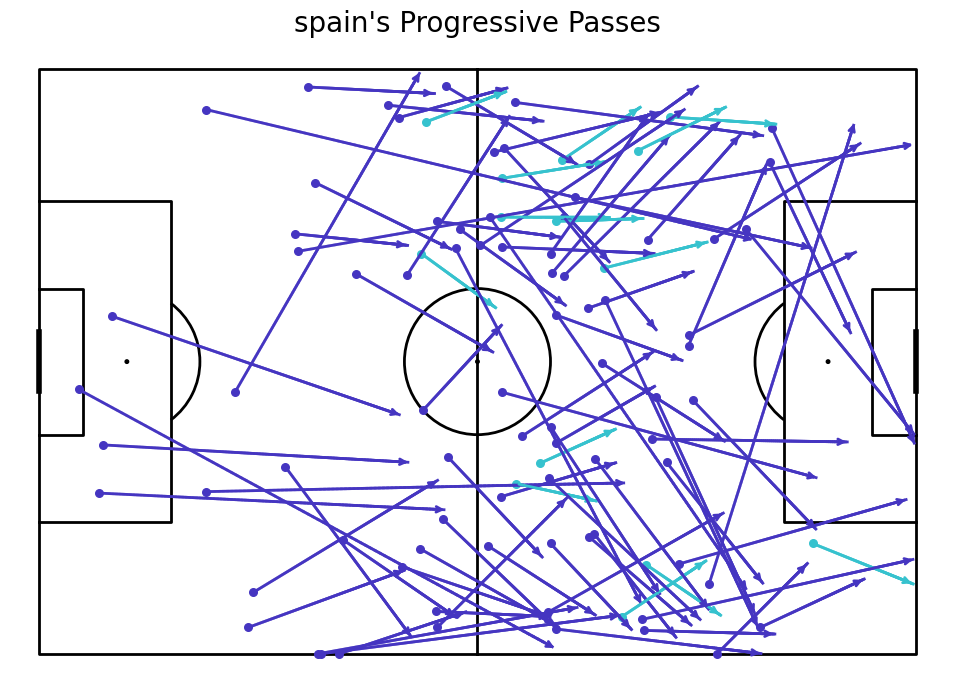

In [14]:
plot_pass_map(spain_prog_passes,color_map=color_map_eng,player_name='spain')

Get the lineup data so we can append the player names to the dataframe

In [18]:

# Filter progressive passes
progressive_passes = prog_pass_df[prog_pass_df['pass_category'] == 'progressive']

# Calculate the total number of progressive passes and completed progressive passes
progressive_pass_counts = progressive_passes.groupby('player_id')['pass_category'].count().reset_index(name='progressive_pass_count')
completed_pass_counts = progressive_passes[progressive_passes['pass_outcome'] != 'Incomplete'].groupby('player_id')['pass_category'].count().reset_index(name='completed_pass_count')

# Merge the total and completed counts
pass_counts = progressive_pass_counts.merge(completed_pass_counts, on='player_id', how='left')

# Calculate the completion percentage
pass_counts['completion_percentage'] = pass_counts['completed_pass_count'] / pass_counts['progressive_pass_count'] * 100

# Merge with player names
progressive_pass_counts_with_names = pass_counts.merge(
    prog_pass_df[['player_id', 'player_name','team_id']].drop_duplicates(),
    on='player_id',
    how='left'
)

# Sort values
progressive_pass_counts_with_names_sorted = progressive_pass_counts_with_names.sort_values('progressive_pass_count', ascending=False)
progressive_pass_counts_with_names_sorted


,player_id,progressive_pass_count,completed_pass_count,completion_percentage,player_name,team_id
3,3468.0,24,11.0,45.833333,Jordan Pickford,768
17,22128.0,19,17.0,89.473684,Robin Aime Robert Le Normand,772
8,5721.0,18,13.0,72.222222,Daniel Carvajal Ramos,772
9,6655.0,14,13.0,92.857143,Fabián Ruiz Peña,772
6,4353.0,14,13.0,92.857143,Aymeric Laporte,772
0,3205.0,11,8.0,72.727273,Kyle Walker,768
15,17620.0,10,9.0,90.000000,Marc Cucurella Saseta,772
13,11748.0,9,5.0,55.555556,Unai Simón Mendibil,772
1,3244.0,9,6.0,66.666667,John Stones,768
24,316046.0,8,6.0,75.000000,Lamine Yamal Nasraoui Ebana,772


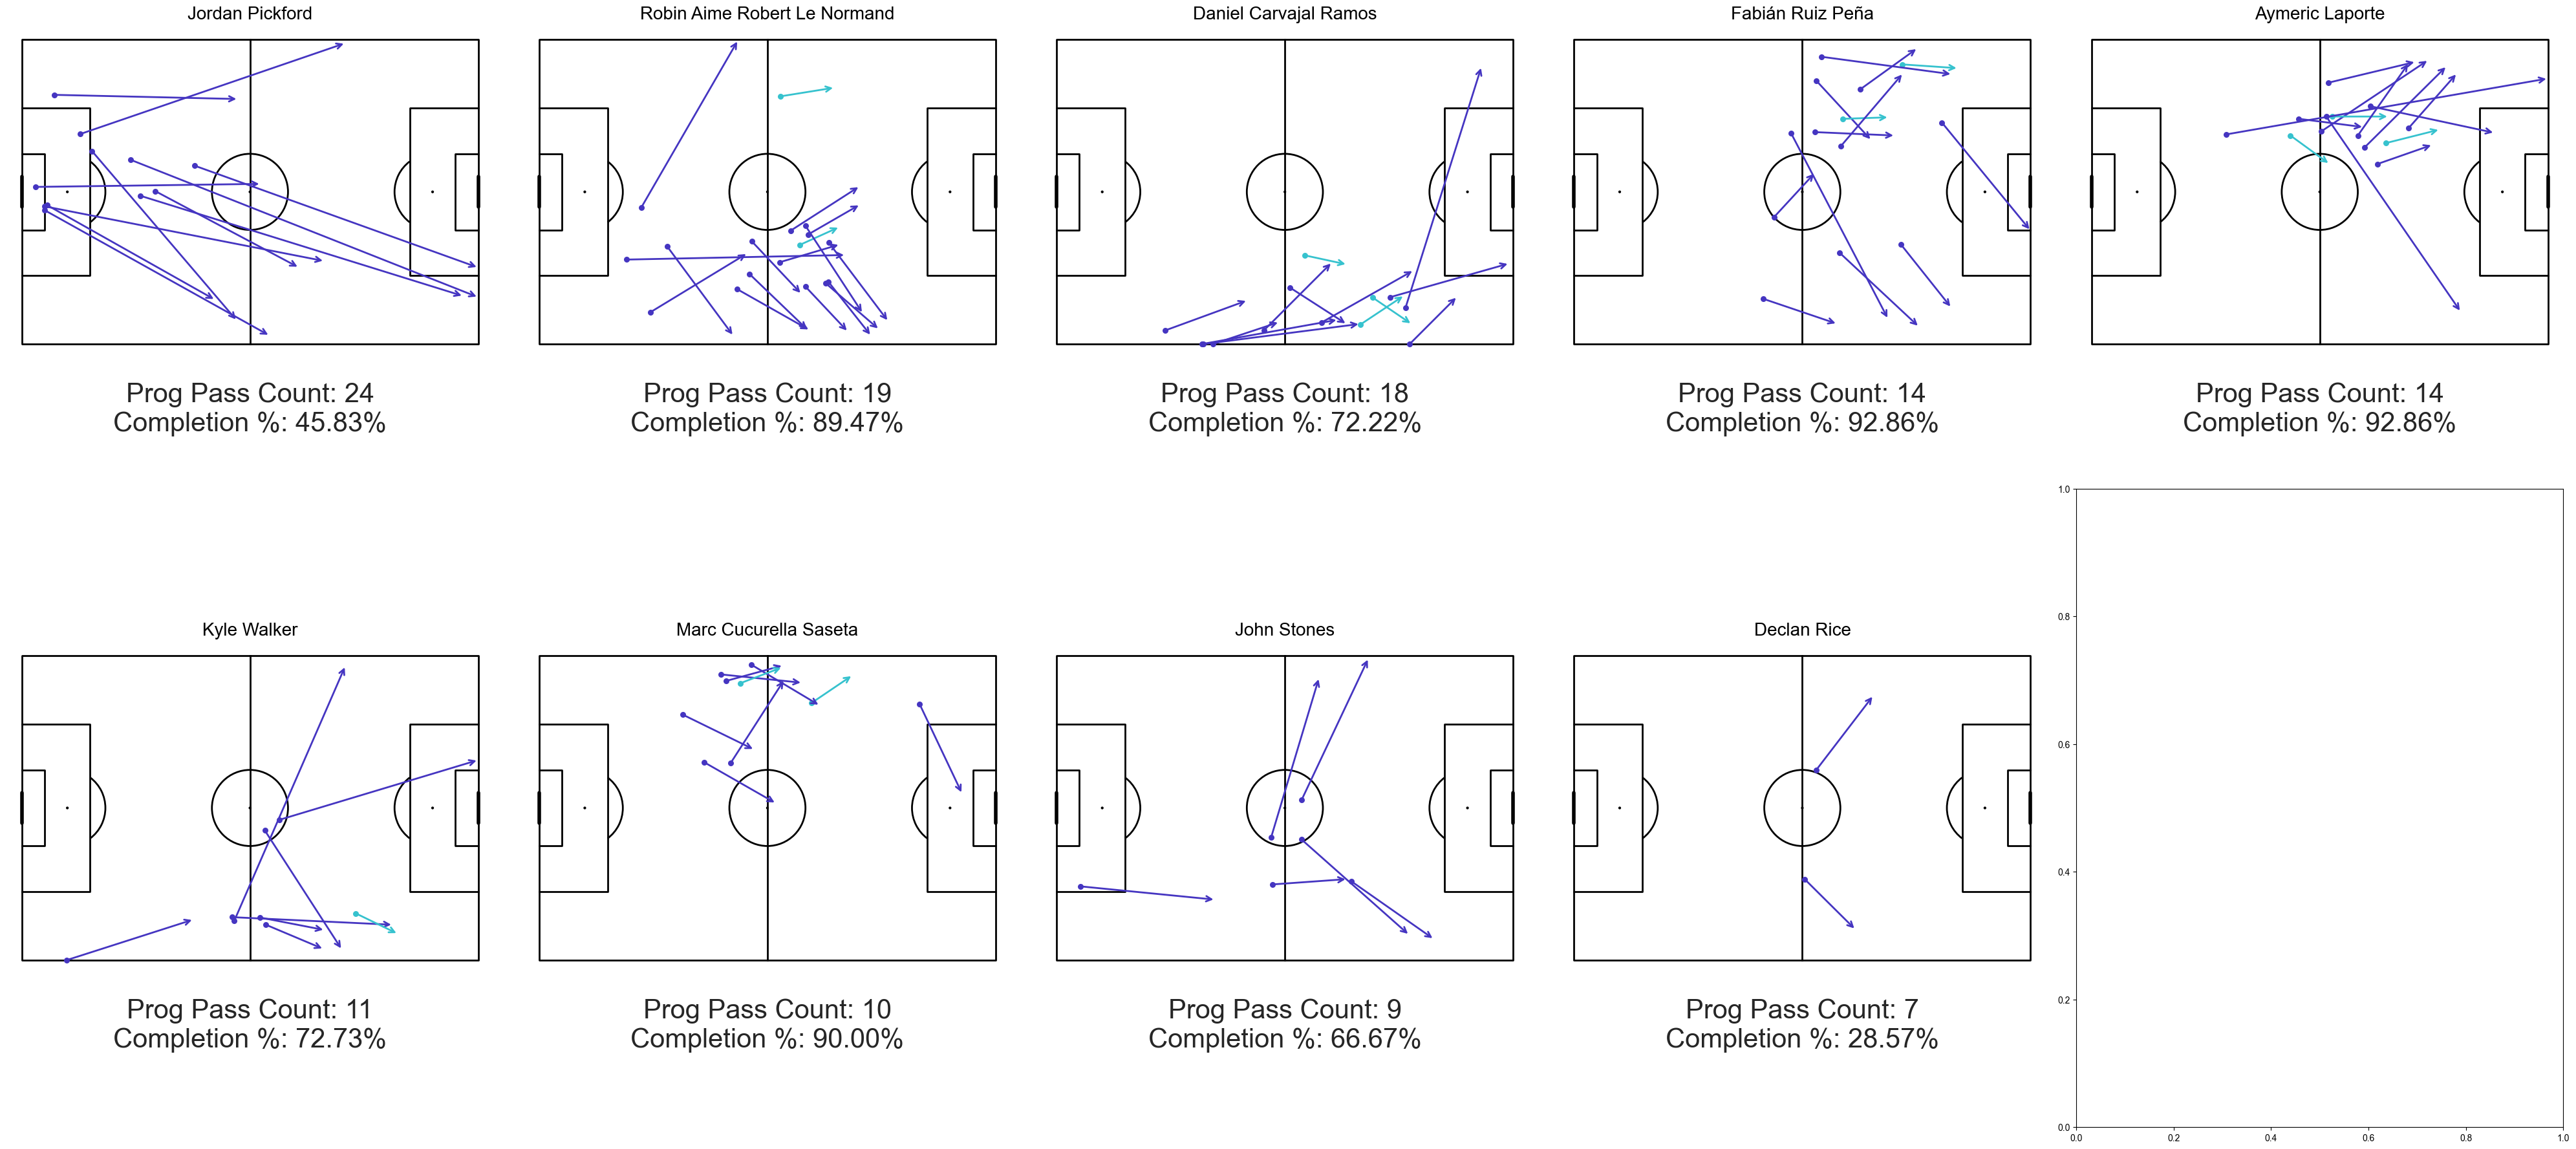

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from matplotlib.patches import FancyArrowPatch
import seaborn as sns

# Function to plot pass map with different colors for different pass lengths
def plot_pass_map(ax, pass_dataframe, color_map, player_name, progressive_pass_counts_df):
    """
    Plots a football pitch with arrows representing passes from the given DataFrame.
    Different pass lengths are color-coded. A small circle is plotted at the source of each pass.
    The player's name is displayed at the top of the plot along with progressive pass count and completion percentage.

    Parameters:
    - ax (matplotlib.axes.Axes): The axes to plot on.
    - pass_dataframe (pd.DataFrame): DataFrame containing pass events with 'location', 'pass_end_location', 'period', 'pass_outcome', and 'pass_length' columns.
    - color_map (dict): Dictionary with color mappings for different pass lengths.
    - player_name (str): Name of the player whose passes are being plotted.
    - progressive_pass_counts_df (pd.DataFrame): DataFrame containing progressive pass counts and completion percentages for players.
    """

    # Get the player's progressive pass stats from the DataFrame
    player_stats = progressive_pass_counts_df[progressive_pass_counts_df['player_name'] == player_name].iloc[0]
    progressive_pass_count = player_stats['progressive_pass_count']
    completion_percentage = player_stats['completion_percentage']

    # Set Seaborn style
    sns.set(style="whitegrid")

    # Create a football pitch
    pitch = Pitch(pitch_type='statsbomb', line_color='black')
    pitch.draw(ax=ax)

    # Plot the passes
    for i, row in pass_dataframe.iterrows():
        start_location = row['location']
        end_location = row['pass_end_location']
        period = row['period']
        pass_outcome = row['pass_outcome']
        pass_length = row['pass_length']
        
        # Check if start_location and end_location are valid lists with no NaN values
        if isinstance(start_location, list) and isinstance(end_location, list):
            if len(start_location) == 2 and len(end_location) == 2:
                # Extract x and y coordinates
                start_x, start_y = start_location
                end_x, end_y = end_location
                
                # Determine the color based on pass length and outcome
                if pass_outcome == 'Incomplete':
                    continue  # Skip incomplete passes
                else:
                    if pass_length <= 5:
                        arrow_color = color_map['short']
                    elif 5 < pass_length <= 15:
                        arrow_color = color_map['medium']
                    else:
                        arrow_color = color_map['long']
                
                # Plot the arrow if all coordinates are valid
                if not (pd.isna(start_x) or pd.isna(start_y) or pd.isna(end_x) or pd.isna(end_y)):
                    # Use FancyArrowPatch for a more customizable arrow
                    arrow = FancyArrowPatch(
                        (start_x, start_y), (end_x, end_y),
                        color=arrow_color,
                        linewidth=2,  # Width of the arrow tail
                        arrowstyle="->,head_length=0.4,head_width=0.2",  # Arrowhead style
                        mutation_scale=15  # Scale of the arrowhead
                    )
                    ax.add_patch(arrow)
                    
                    # Plot a small circle at the source of the pass
                    pitch.scatter(start_x, start_y, s=30, color=arrow_color, ax=ax)

    # Add the player's name as the title
    ax.set_title(f"{player_name}", fontsize=20)

    # Add text with progressive pass count and completion percentage below the plot
    ax.text(60,90, f"Prog Pass Count: {progressive_pass_count}\nCompletion %: {completion_percentage:.2f}%", fontsize=30, ha='center', va='top', transform=ax.transData)

# Define the grid size (2 rows, 5 columns)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(40, 20))

# Flatten the axes array for easy iteration
axes = axes.flatten()

sc = 5
ec = 5
plot_index = 0  # To track the plot index

for index, row in progressive_pass_counts_with_names_sorted.iterrows():
    if sc == 0 and ec == 0:
        break
    player = row['player_name']
    player_specific_df = prog_pass_df[prog_pass_df['player_name'] == player]
    if row['team_id'] == team1_id:
        ec=ec-1
        if(ec<=0):
            continue
    else:
        sc=sc-1
        if(sc<0):
            continue
    if plot_index < len(axes):
        ax = axes[plot_index]
        plot_pass_map(ax, player_specific_df, color_map=color_map_eng, player_name=player, progressive_pass_counts_df=progressive_pass_counts_with_names_sorted)
        plot_index += 1

plt.tight_layout()
plt.show()


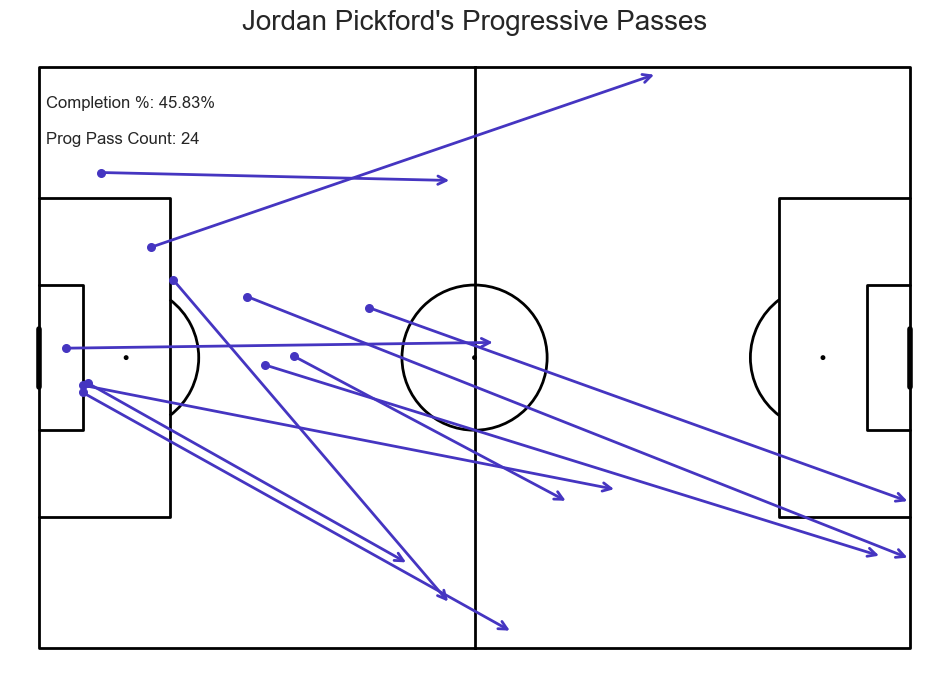

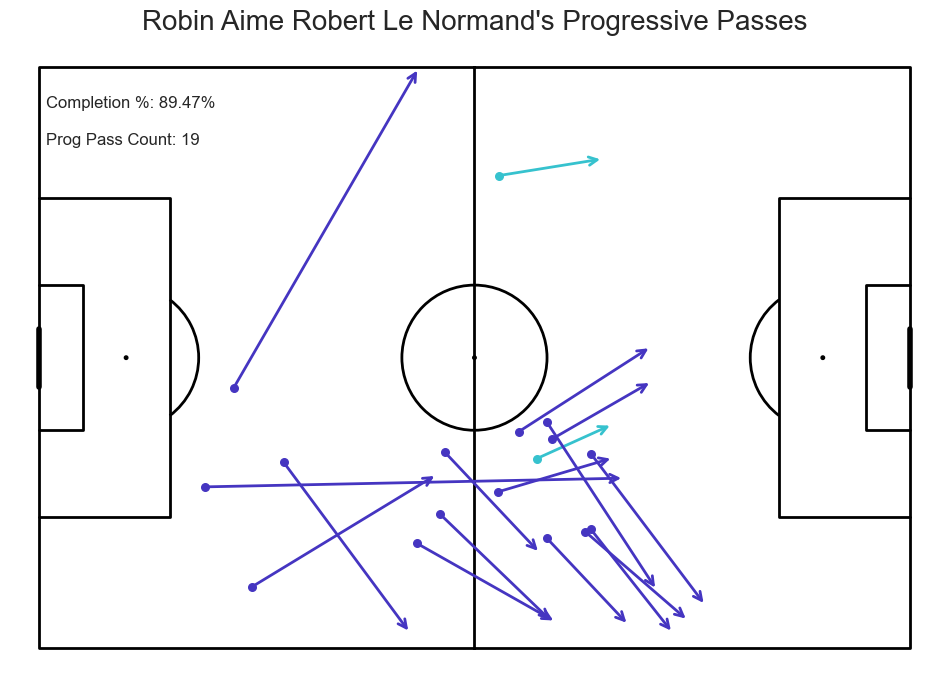

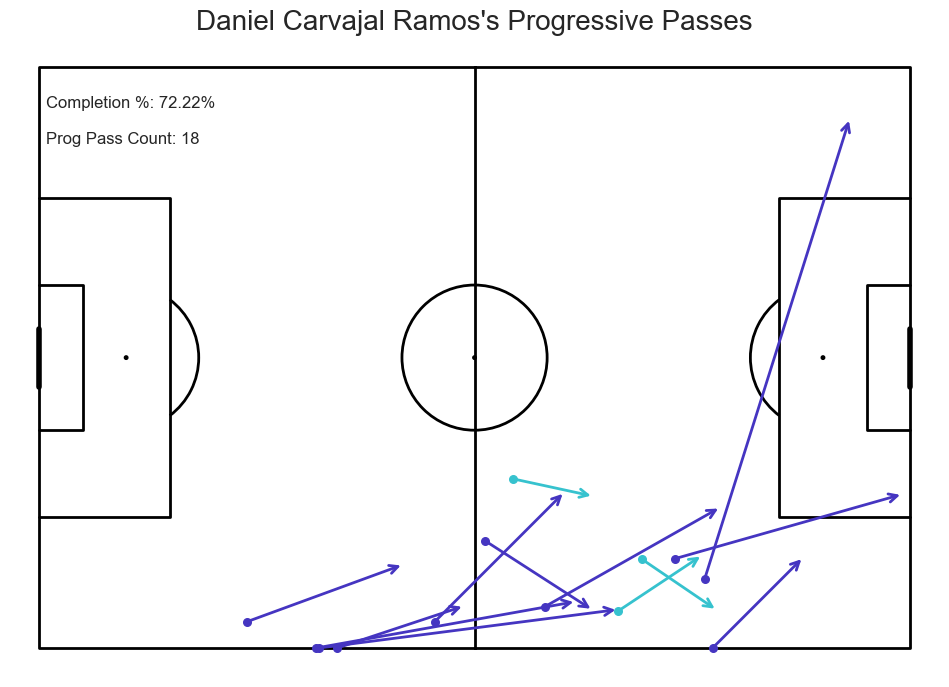

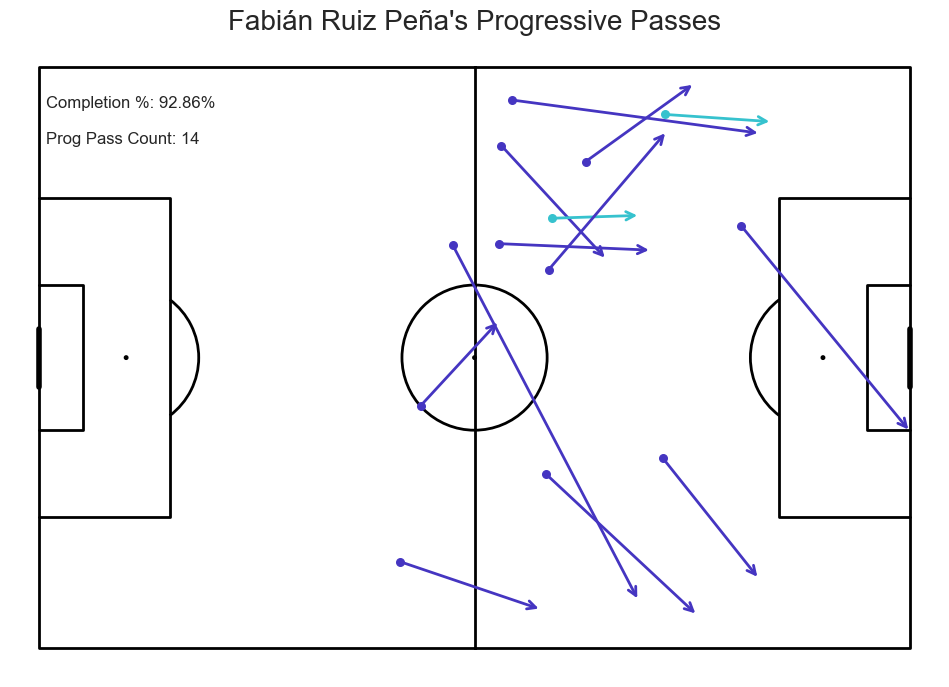

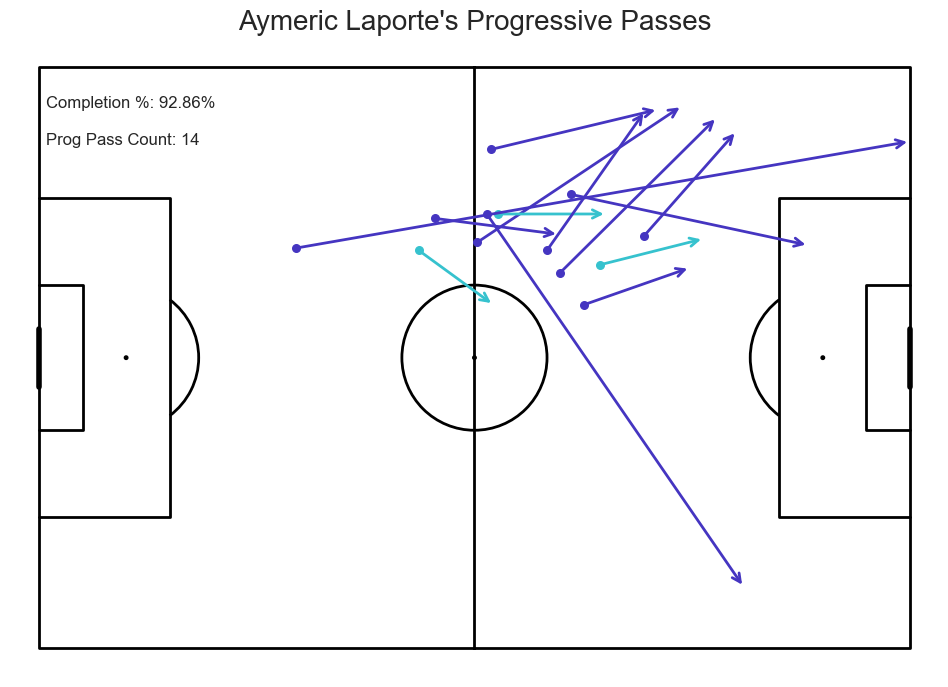

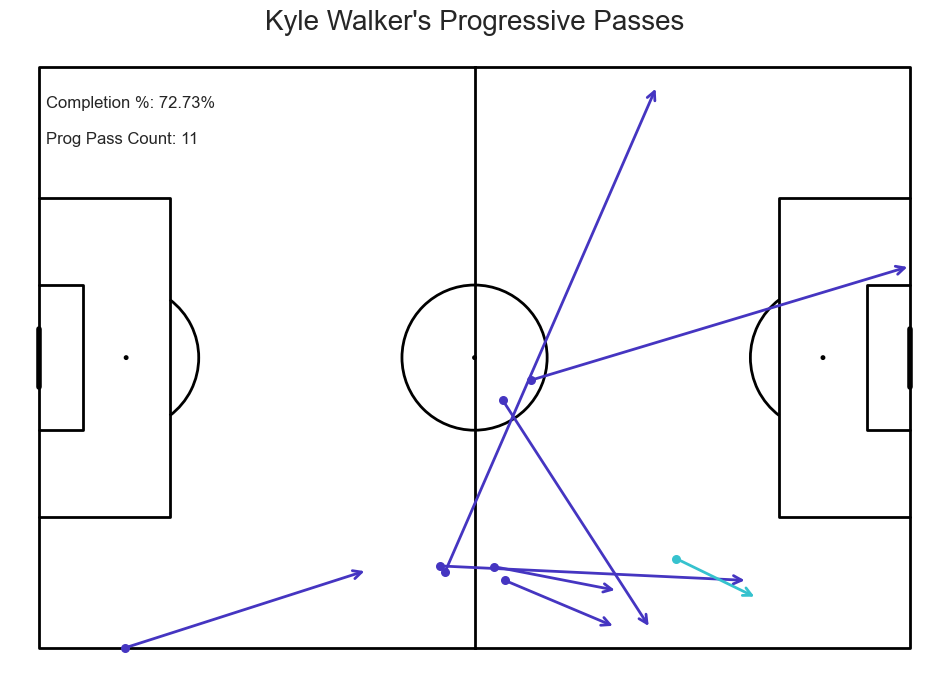

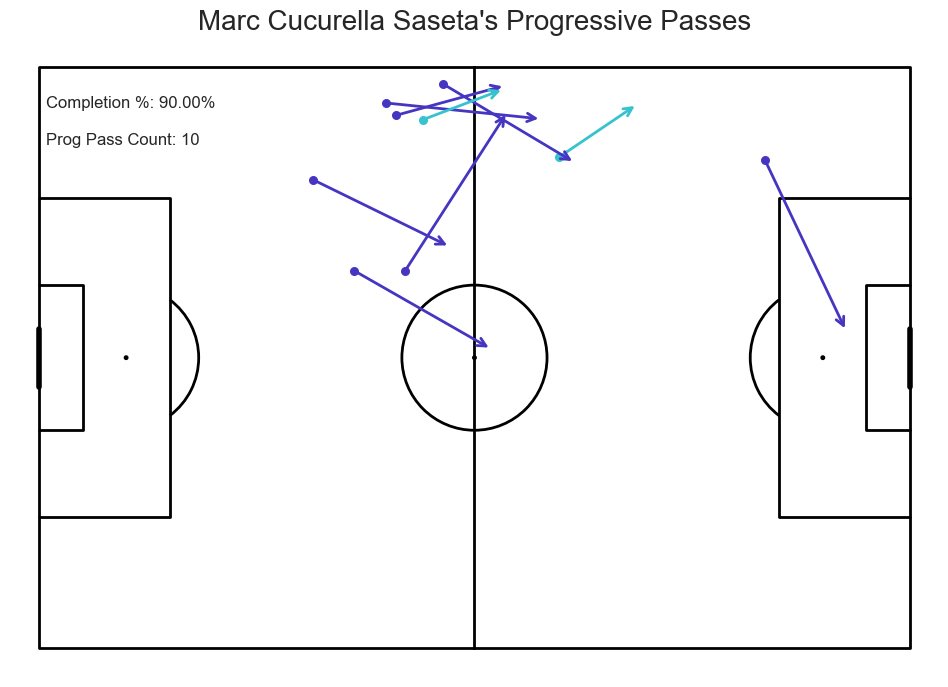

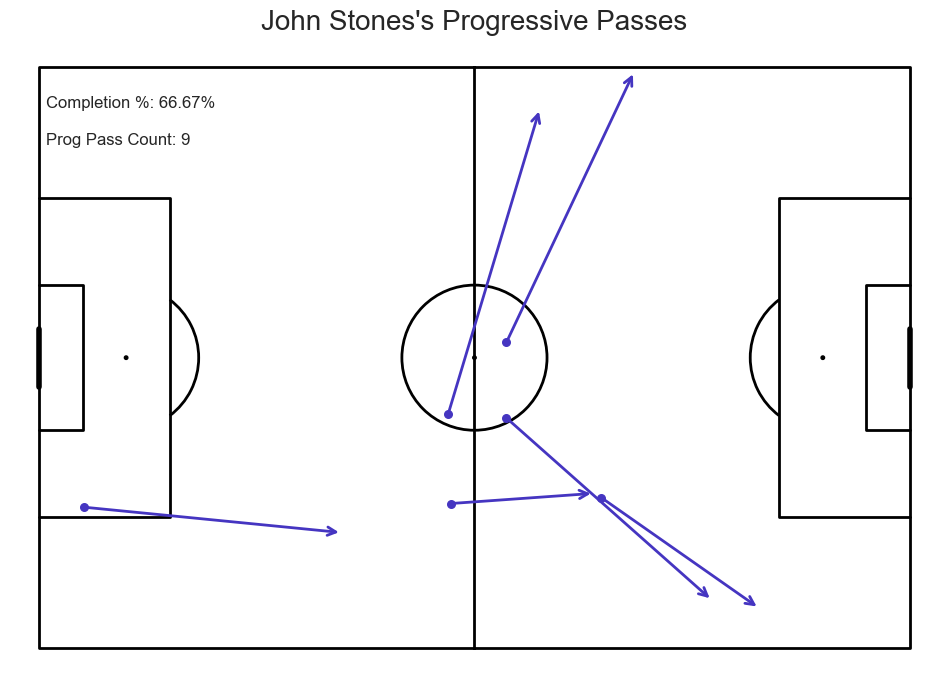

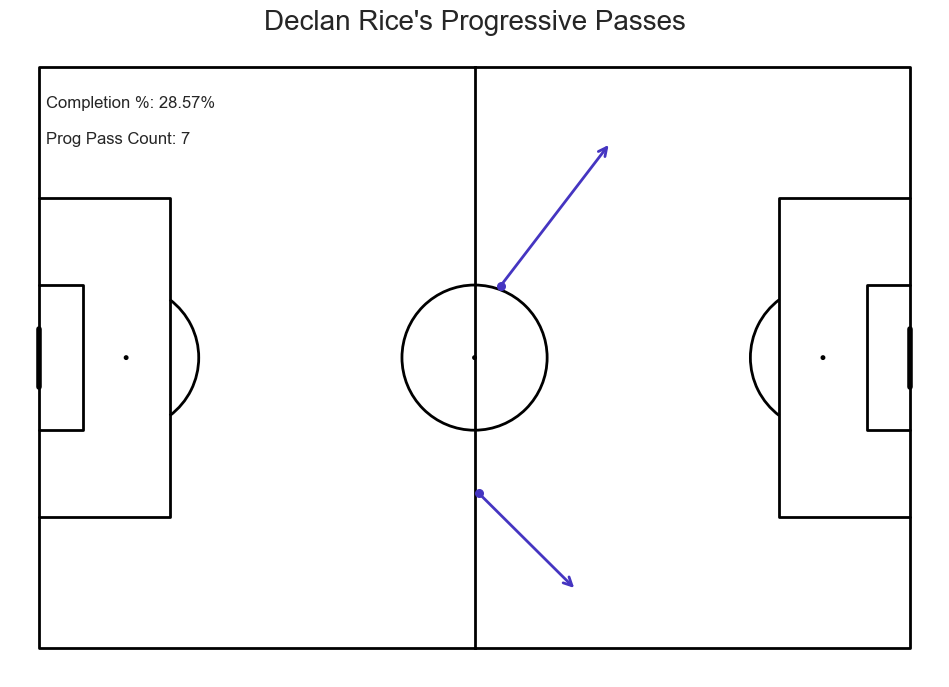

In [17]:
sc = 5
ec = 5

for index, row in progressive_pass_counts_with_names_sorted.iterrows():
    if(sc == 0 and ec== 0 ):
        break
    player = row['player_name']
    player_specific_df = prog_pass_df[prog_pass_df['player_name']==player]
    if(row['team_id']==team1_id):
        ec=ec-1
        if(ec<=0):
            continue
    else:
        sc=sc-1
        if(sc<0):
            continue
    plot_prog_pass_map(player_specific_df,progressive_pass_counts_with_names_sorted,color_map=color_map_eng,player_name=player)